In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns;

Importamos a base, ja transformando os tipos de dados inteiros em decimal

In [2]:
tipos_inteiros = { 'CASH_ADVANCE_TRX':'float64', 'PURCHASES_TRX':'float64', 'TENURE':'float64' }
base = pd.read_csv('./dados/credit_card.csv', dtype=tipos_inteiros)

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null float64
PURCHASES_TRX                       8950 non-null float64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS        

Temos 314 linhas possuem valores nulos, vamos preenche-los com o valor médio

In [4]:
base = base.fillna(base.median())

## Analise descritiva dos dados
Aqui vamos entender o comportamento dos dados

In [5]:
colunas = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
    'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
    'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

In [6]:
def imprimir_distribuicao(base, variavel):
    plt.figure(figsize=[15, 6])

    plt.subplot(211)
    plt.hist(base[variavel])
    plt.title('Distribuição da variavel ' + variavel)

    plt.subplot(212)
    plt.boxplot(base[variavel], vert=False)

    plt.show()

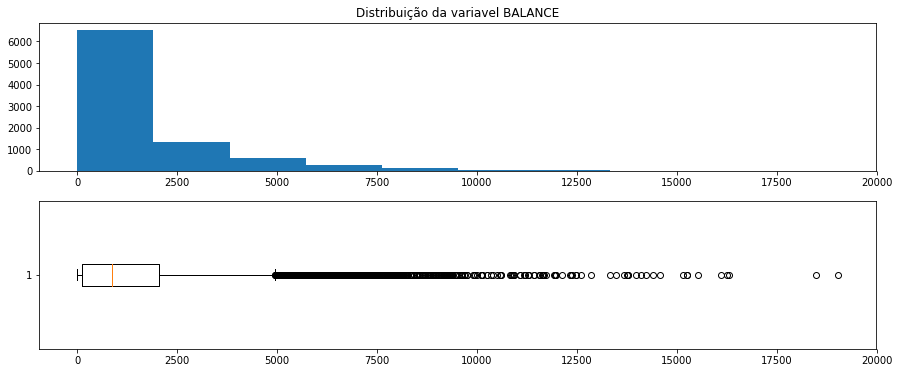

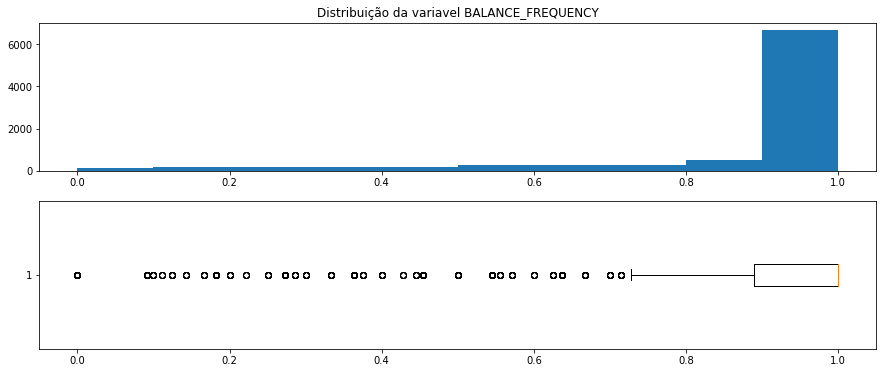

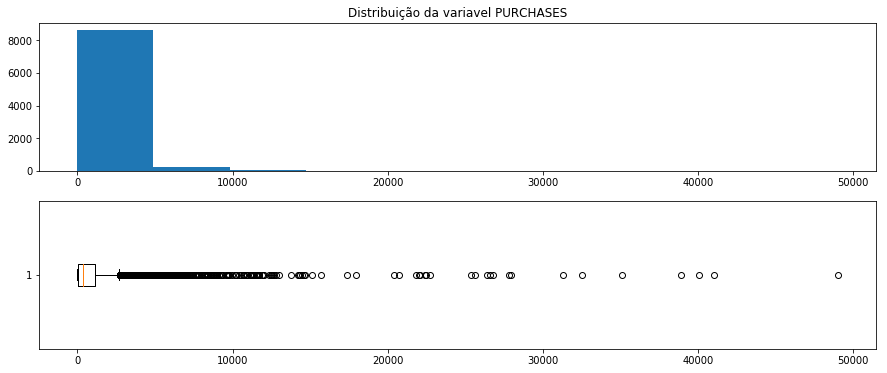

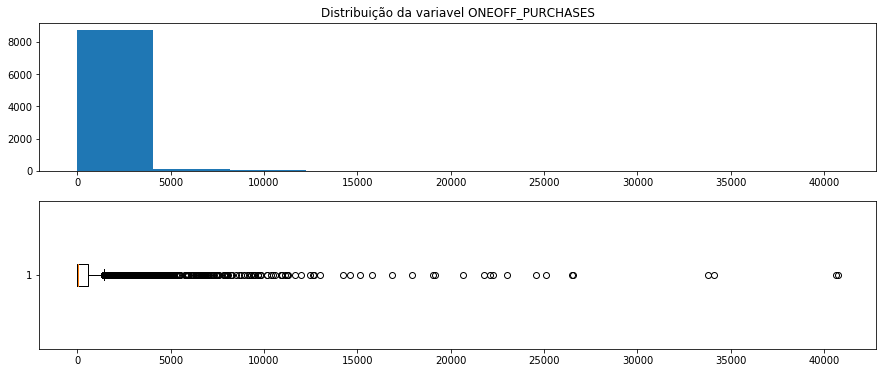

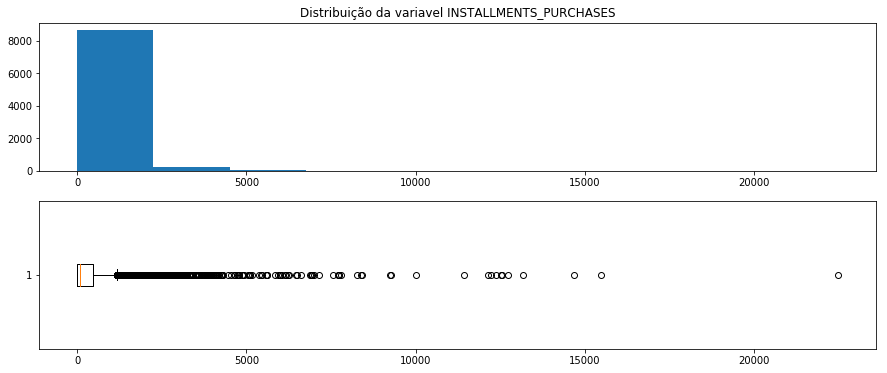

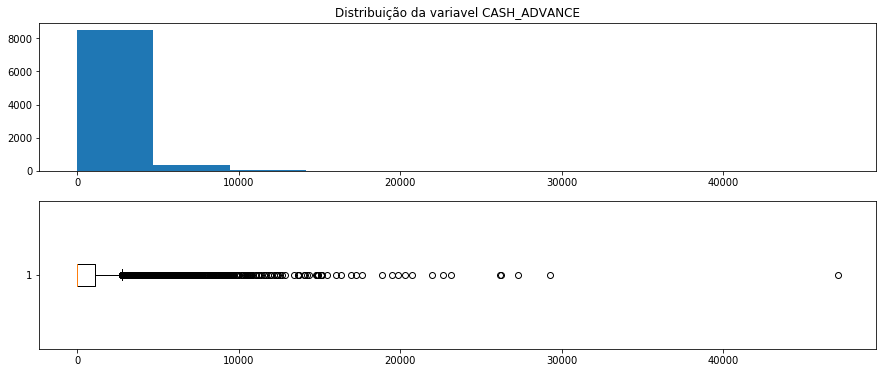

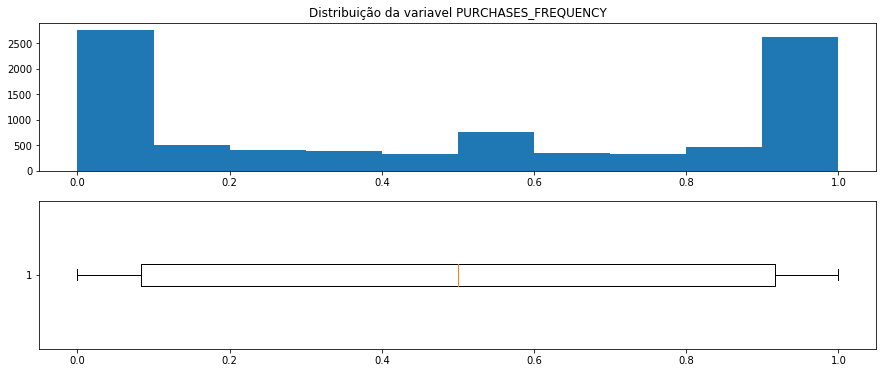

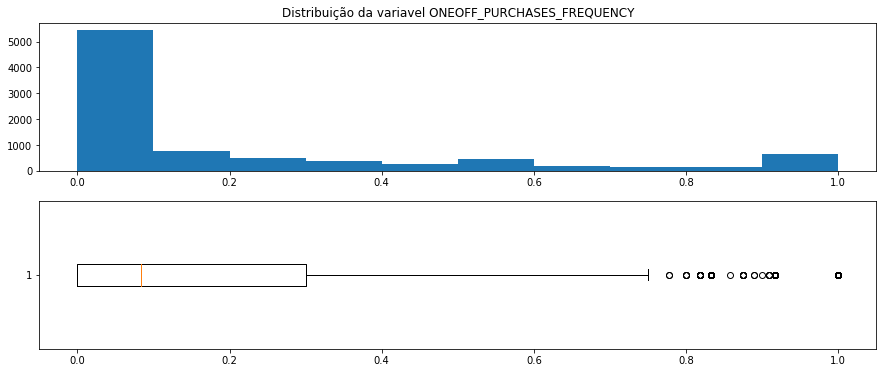

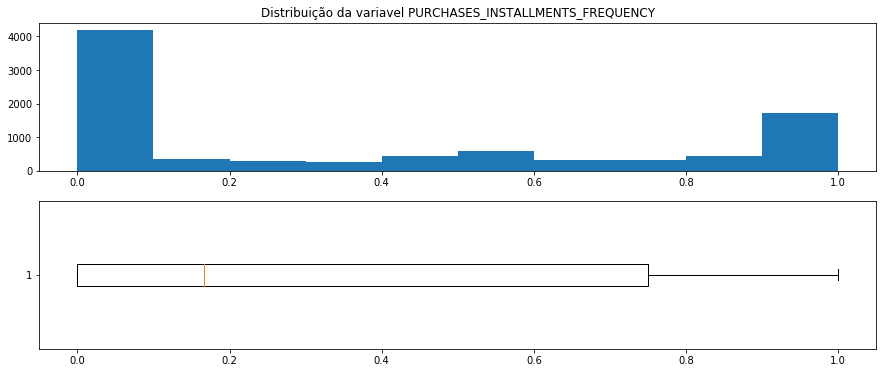

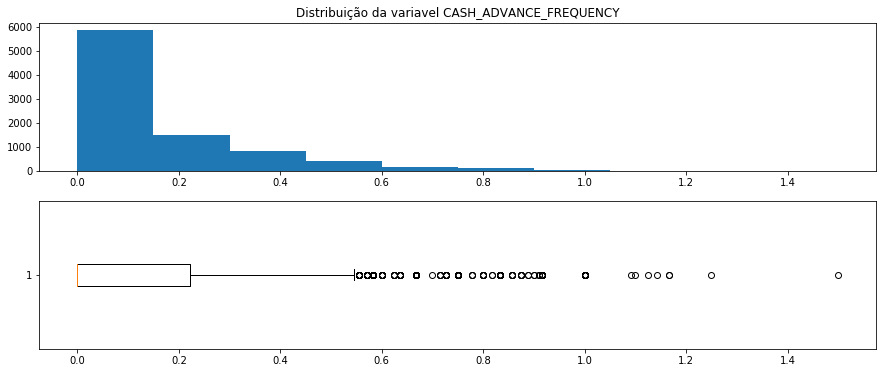

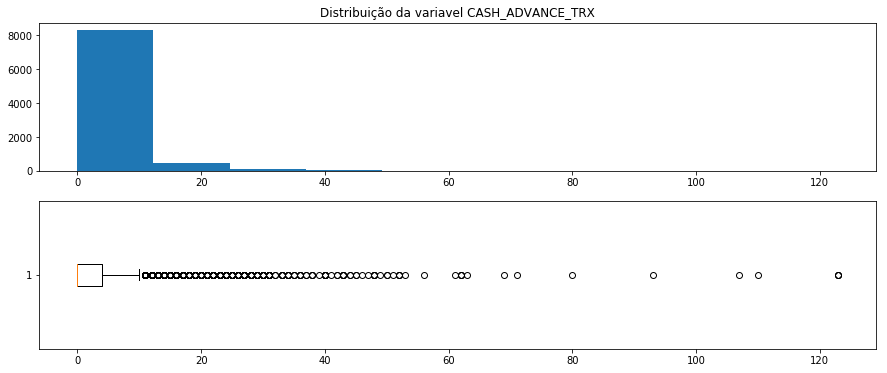

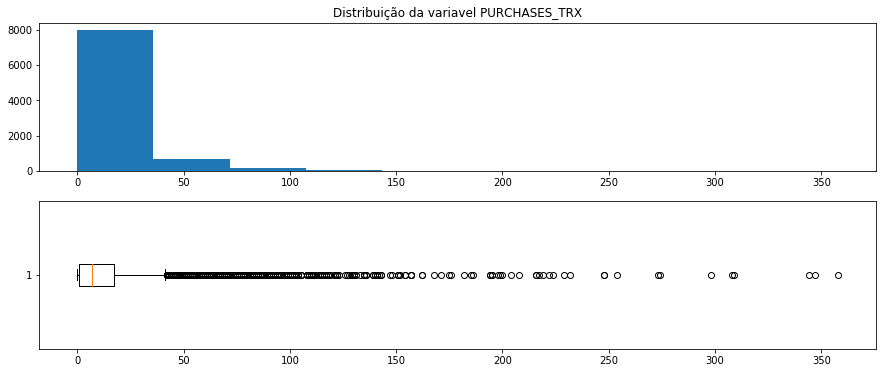

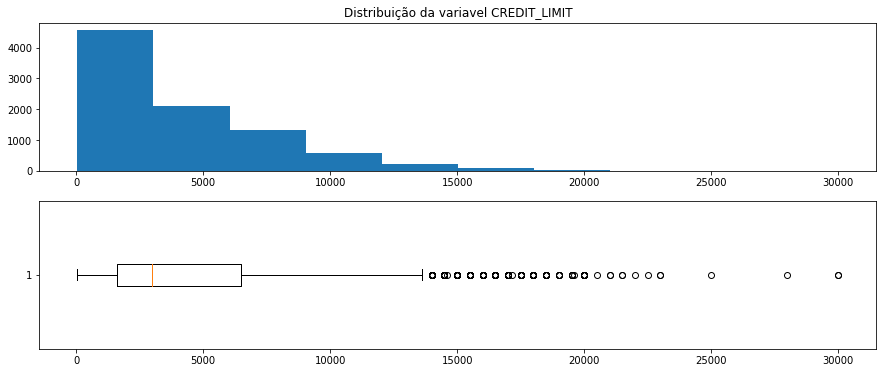

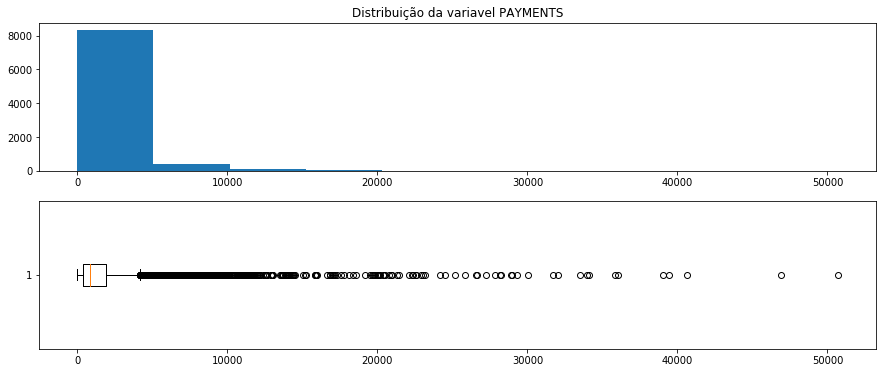

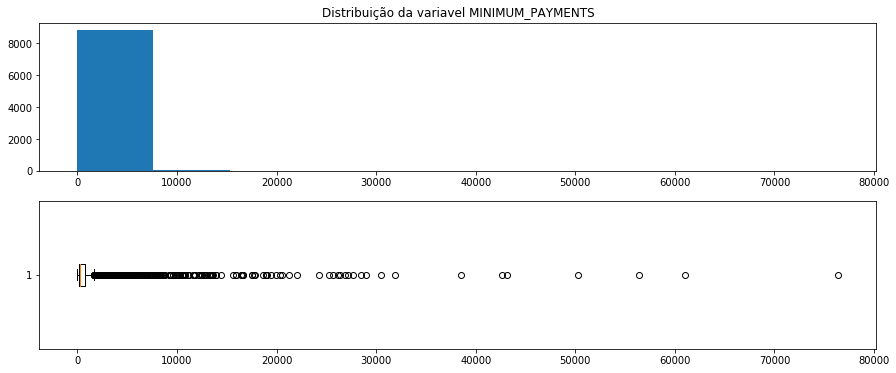

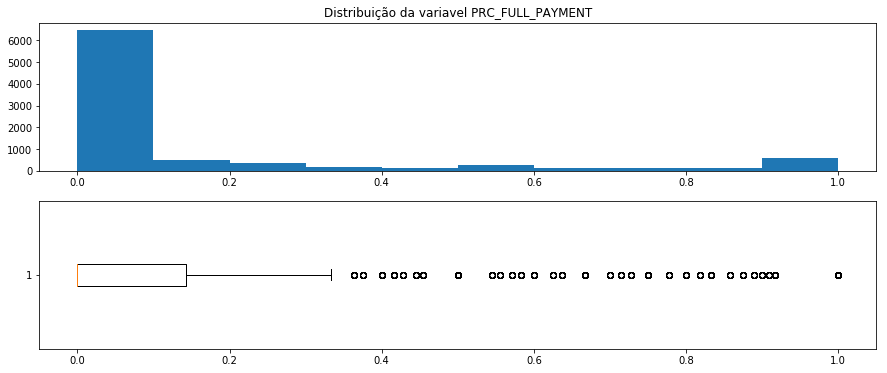

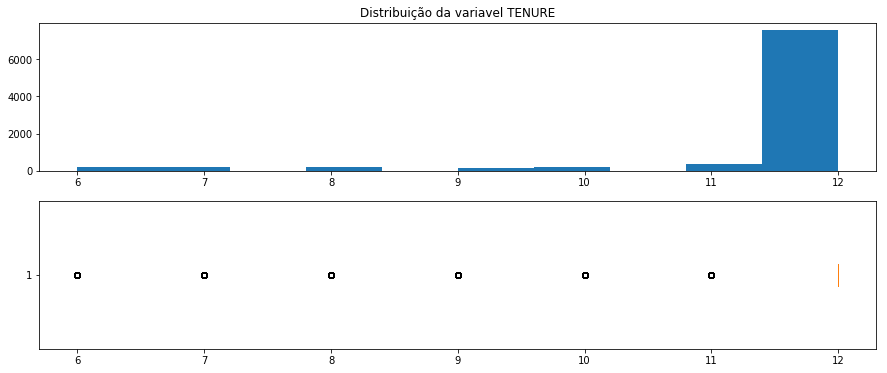

In [7]:
for coluna in colunas:
    imprimir_distribuicao(base, coluna)

Agora vamos olhar a correlação entre as variaveis

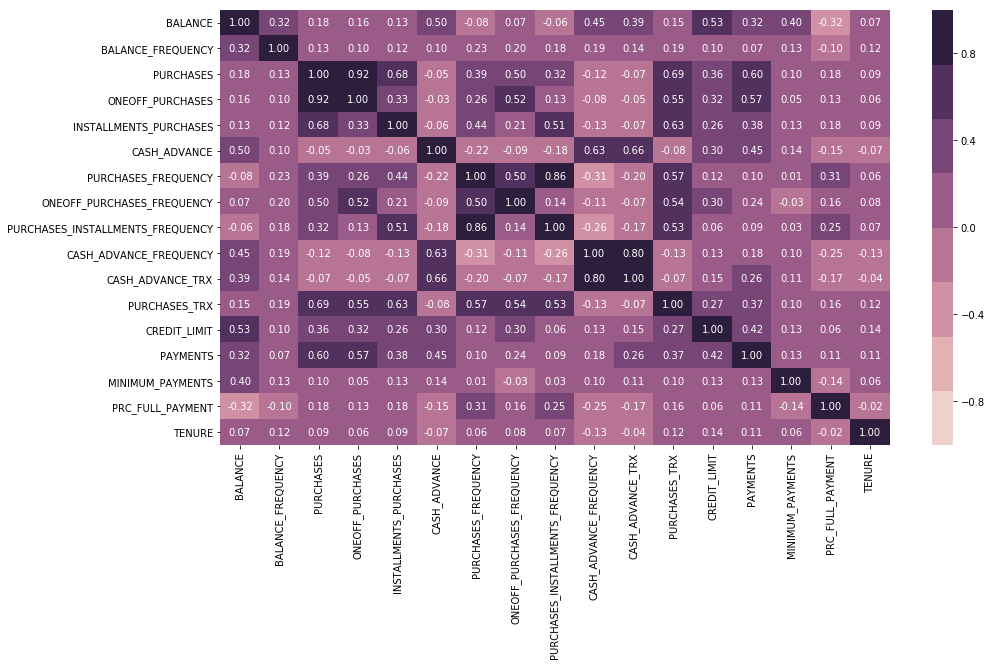

In [8]:
plt.figure(figsize=[15, 8])
sns.heatmap(base.corr(), annot=True, fmt=".2f", vmax=1, vmin=-1, cmap=sns.cubehelix_palette(8))
plt.show()

A variavel TERNURE possui muito pouca variação, então vamos remover ela do estudo

Os grupos de  variaveis a seguir possuem uma correlção forte entre elas, portanto utilizarei apenas uma delas:
1. [PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY]
2. [CASH_ADVANCE, CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX]
3. [PURCHASES, ONEOFF_PURCHASES]

A variavel BALANCE_FREQUENCY, pela descrição não parece ser muito ineressante para entrar na clusterização

As variaveis MINIMUM_PAYMENTS e PRC_FULL_PAYMENT são inversas, portanto utilizarel apenas uma delas

As variaveis BALANCE e PURCHASES são inversas, portanto utilizarel apenas uma delas

In [10]:
colunas = [
    'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
    'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']

## Transformação dos dados
Como as variaveis estão em escala diferentes vamos colocalas na mesma escala para que a variação em cada variavel tenha um peso igual na clusterização

In [11]:
transformador = {}

for coluna in colunas:
    min_max = MinMaxScaler().fit(base[[coluna]])
    base[coluna] = min_max.transform(base[[coluna]])
    transformador.update({ coluna:min_max })

## Clusterização
Vamos utilizar o algoritmo k-means, mas antes disso precismaos definir um numero de cluster ideal para essa base. O metodo escolhido para isso fo utilizando o grafico de cotovelo

In [12]:
distancia = []

for n_cluster in range(1, 21):
    kmeans = KMeans(n_clusters=n_cluster, random_state=12345).fit(base[colunas])
    
    distancia.append(
        sum(np.min(cdist(base[colunas], kmeans.cluster_centers_, 'euclidean'), axis=1)) / len(colunas)
    )

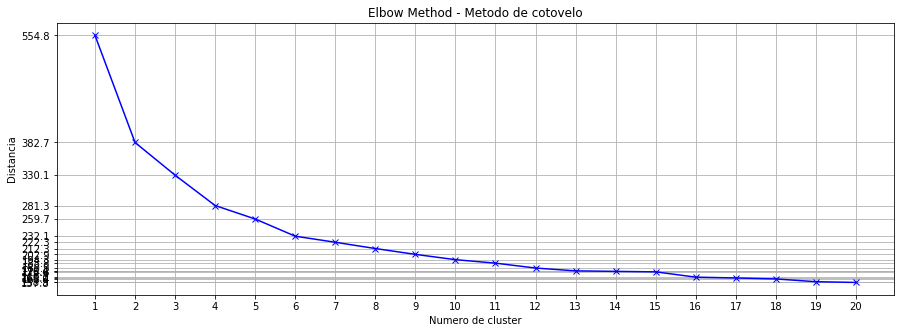

In [13]:
plt.figure(figsize=[15, 5])
plt.grid(True)

plt.xlabel('Numero de cluster')
plt.xticks(range(1, 21))

plt.ylabel('Distancia')
plt.yticks(distancia)

plt.title('Elbow Method - Metodo de cotovelo')

plt.plot(range(1, 21), distancia, 'bx-')
plt.show()

Olhando para o grafico, 6 clusters parece ser o numero ideal para fazermos a clusterização

In [14]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=12345)
kmeans = kmeans.fit(base[colunas])

In [15]:
base['CLUSTER'] = pd.Series(kmeans.predict(base[colunas]))

## Analise do grupos

Vamos voltar as variaveis as suas escalas normais para podermos entender como ficaram os clusters

In [16]:
for coluna in colunas:
    min_max = transformador[coluna]
    base[coluna] = np.round(min_max.inverse_transform(base[[coluna]]), 2)

Quantidade de pessoas em cada cluster

In [17]:
base.groupby(by='CLUSTER')['BALANCE'].count()

CLUSTER
0    1579
1    1700
2    1050
3    3374
4     390
5     857
Name: BALANCE, dtype: int64

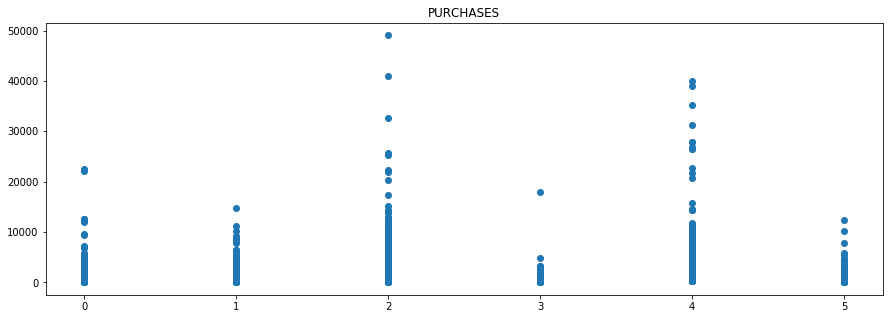

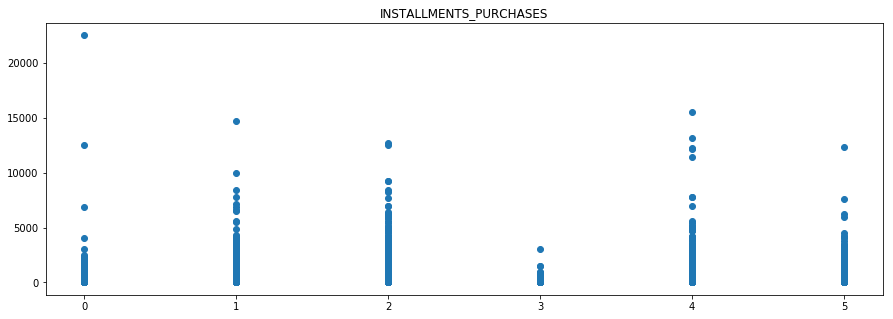

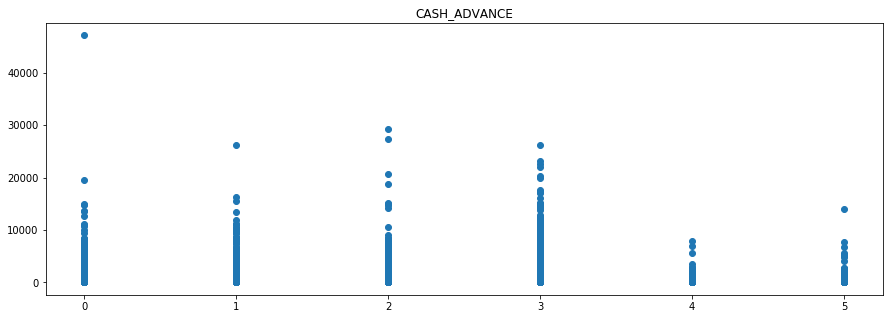

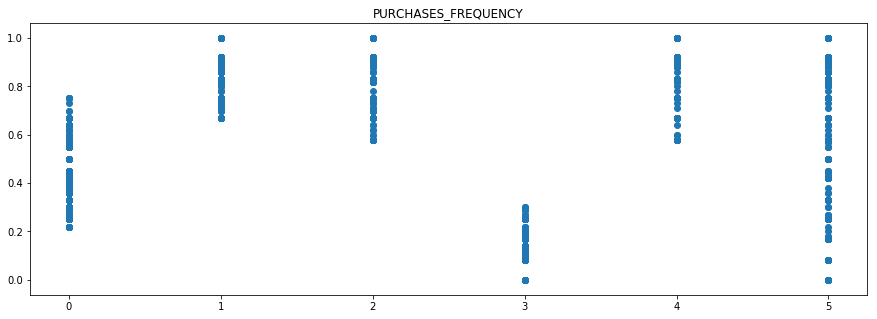

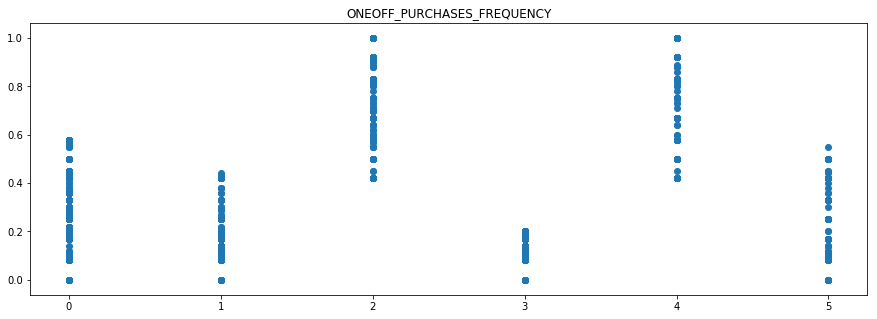

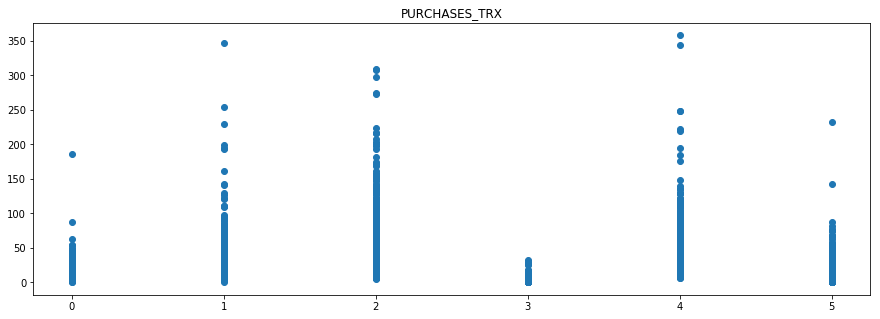

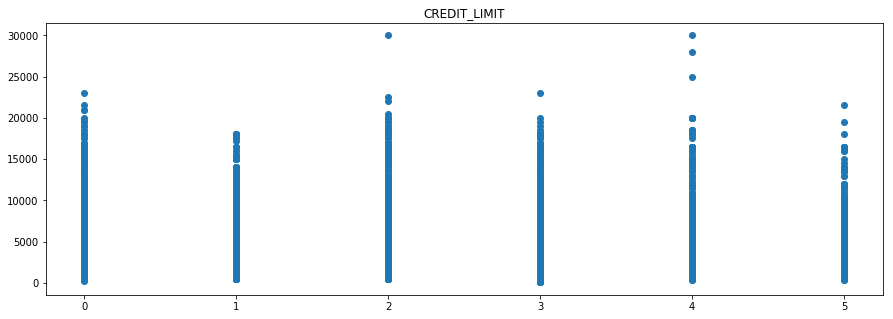

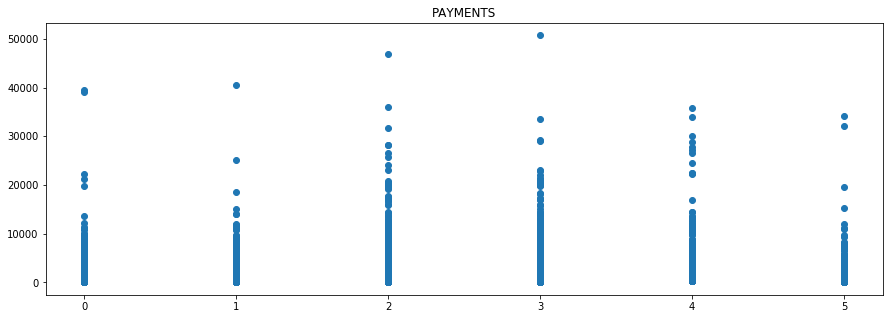

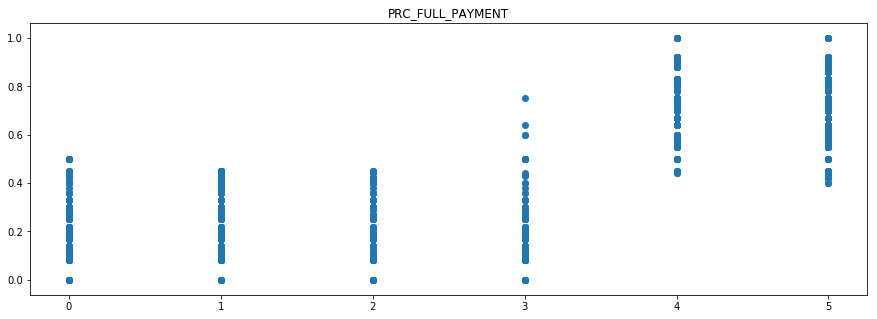

In [18]:
for coluna in colunas:    
    plt.figure(figsize=[15, 5])
    plt.title(coluna)
    plt.scatter(base['CLUSTER'], base[coluna])
    plt.xticks(range(0, n_clusters))
    plt.show()

## Conclusão
A partir da clusterização e da analise sobre a distribuição dos cluster nas metricas utilizadas podemos definir que existem os seguintes grupos:

Grupo 0:
* Possui 1579 pessoas
* Possui frequencia de compra mediana

Grupo 1:
* Possui 1700 pessoas
* Possui alta frequencia de compra

Grupo 2:
* Possui 1050 pessoas
* Possui alta frequencia de compra
* Normalmente faz compras a vista

Grupo 3:
* Possui 3374 pessoas
* Tem o valor de compra baixo
* Possui baixa frequencia de compra
* Raramente faz compra a vista

Grupo 4:
* Possui 390 pessoas
* Possui alta frequencia de compra
* Normalmente faz compras a vista
* Normalmente paga a fatura inteira

Grupo 5:
* Possui 857 pessoas
* Normalmente paga a fatura inteira